In [16]:
import math
import datetime
import yaml
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Categorical

from sklearn.metrics import mean_squared_error


import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

from models_prior import *
from datasets import *
from figures import *
from kernels import *

import warnings
warnings.filterwarnings("ignore")

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
class ExactGP_Regression(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGP_Regression, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(kernel)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [19]:
def sample_gpp(model ,x, n_samples):
        """sample functions from a GP prior"""
        model.eval()
        likelihood.eval()
        # sample functions
        model.train_inputs = None
        preds = model(x)
        y = torch.stack([preds.sample() for i in range(n_samples)])
        return y

def sample_bnn(model ,x, n_samples, train=True):
    """samples functions from a bnn"""
    if train == False:
        model.eval()
        with torch.no_grad():
            # sample functions
            y = torch.stack([model(x) for i in range(n_samples)])
            return y
    else:
        return torch.stack([model(x) for i in range(n_samples)])

In [20]:
def fit(model, kernel, optimizer, epochs, verbose, writer=None):
    """Full training loop"""

    print("Training on", 'GPU' if device.type == 'cuda' else 'CPU', '\n')
    def train_epoch():
        """
        Returns:
            The epoch loss
        """
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Calc loss and backprop gradients
        loss = kl_objective(bnn)
        loss.backward()
        optimizer.step()
        return loss.item()
    def covariance(x_1,x_2, kenrel):
        return kernel(x_1,x_2).evaluate()

    def log_gp_prior(y_bnn, x):
        """computes: the expectation value of the log of the gp prior"""
    
        s = 0.1*torch.eye(x.shape[0])
        K = covariance(x, x, kernel)+s
        L = torch.linalg.cholesky(K)
        a = torch.linalg.solve(L, y_bnn)
        log_gp = -0.5*torch.mean(a**2, axis=0)
        return log_gp
    def entropy_estimate(y_bnn, x):
        """ entropy estimate """
        entropy = -0.001
        return entropy

    def kl_objective(bnn):
        """
        Provides a stochastic estimate of the kl divergence
        """
        x = torch.FloatTensor(400, 1).uniform_(-10, 10)  # X ~ p(X)
        y_bnn = sample_bnn(bnn, x, 20).T.squeeze(0)
        kl_div = torch.mean(log_gp_prior(y_bnn, x))
        return -kl_div  # the KL

    for epoch in range(0, epochs):
        loss = train_epoch()
        if verbose:
            print(f"Epoch {epoch}/{epochs}, KL: {loss:.4f}")
        if writer:
            writer.add_scalars("KL",loss , epoch)
    print("\nFinished.")

Experimenting with : 
 	epochs=100_no_tensorboard=True_num_examples=100_sample=True_experiment=True_verbose=False
Training on CPU 


Finished.
Experimenting with : 
 	epochs=100_no_tensorboard=True_num_examples=100_sample=True_experiment=True_verbose=False
Training on CPU 


Finished.
Experimenting with : 
 	epochs=100_no_tensorboard=True_num_examples=100_sample=True_experiment=True_verbose=False
Training on CPU 


Finished.
Experimenting with : 
 	epochs=100_no_tensorboard=True_num_examples=100_sample=True_experiment=True_verbose=False
Training on CPU 


Finished.
Experimenting with : 
 	epochs=100_no_tensorboard=True_num_examples=100_sample=True_experiment=True_verbose=False
Training on CPU 


Finished.
Experimenting with : 
 	epochs=100_no_tensorboard=True_num_examples=100_sample=True_experiment=True_verbose=False
Training on CPU 


Finished.
Experimenting with : 
 	epochs=100_no_tensorboard=True_num_examples=100_sample=True_experiment=True_verbose=False
Training on CPU 


Finished.

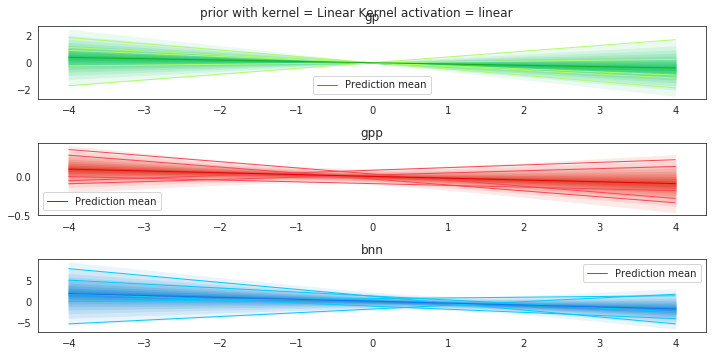

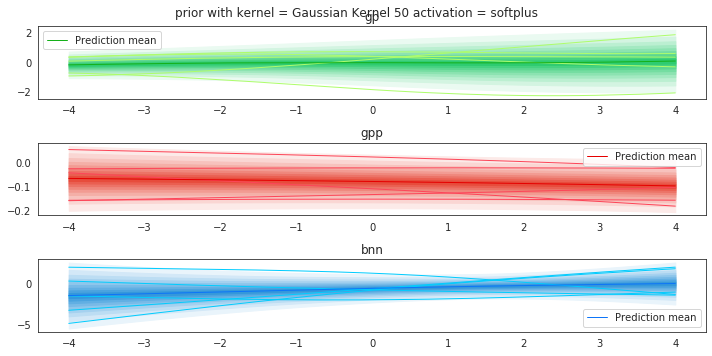

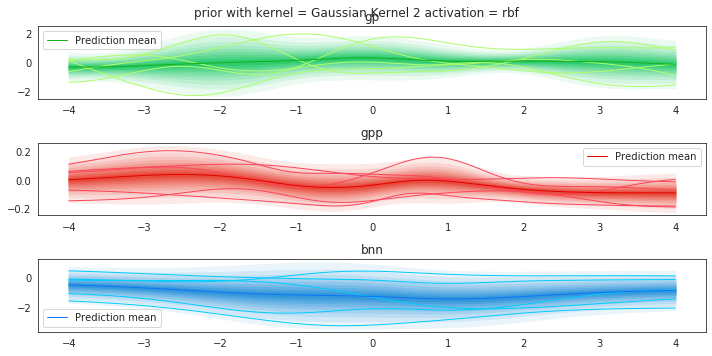

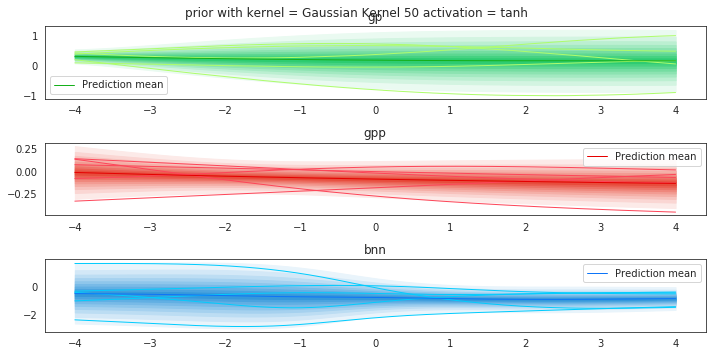

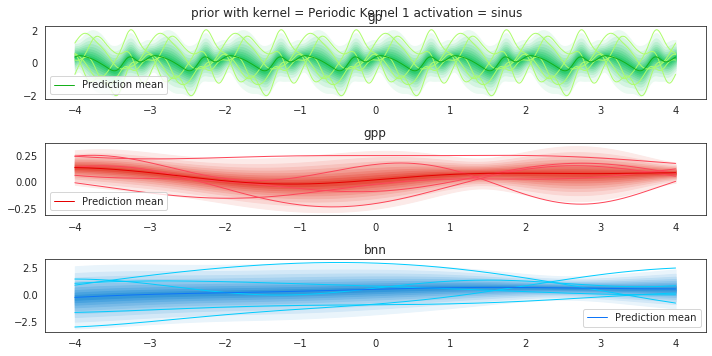

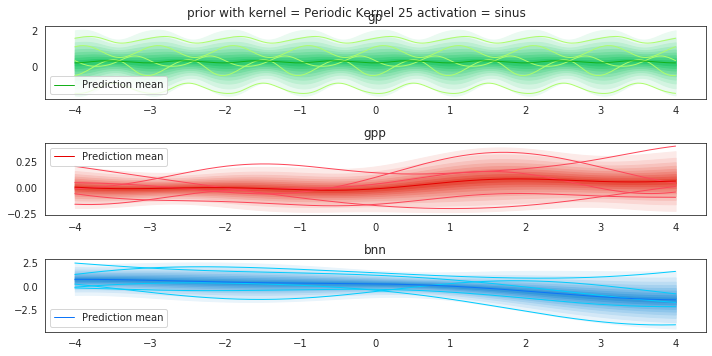

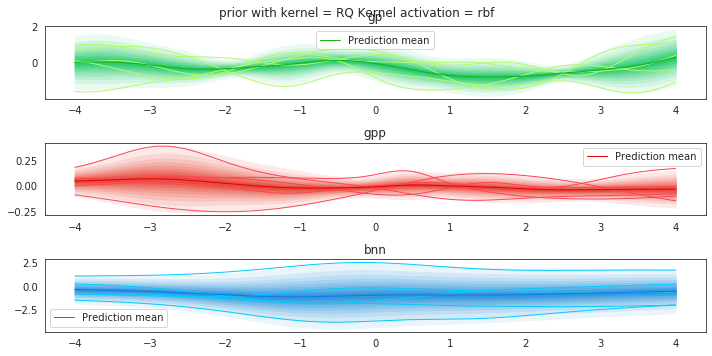

In [21]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device("cpu")
    kernel_activation = [("Linear Kernel", "linear"), ("Gaussian Kernel 50", "softplus"), ("Gaussian Kernel 2", "rbf"), ("Gaussian Kernel 50", "tanh"),\
                    ("Periodic Kernel 1", "sinus"), ("Periodic Kernel 25", "sinus"), ("RQ Kernel", "rbf")]

    # Load args

    # data paths args
    with open('../configs/gpp_bnn.yaml', 'r') as stream:
        gpp_bnn_args  = yaml.load(stream,Loader=yaml.Loader)

    if gpp_bnn_args["experiment"] == False:
        kernel_activation = [("Gaussian Kernel 2", "rbf")]
    # define GP
    # ficticious data
    train_x = torch.linspace(0, 1, 100)
    train_y = torch.sin(train_x * (100 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)
    # initialize likelihood
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    for couple in kernel_activation:
        kernel_name, activation = couple
        # initialise model
        kernel = all_kernels[kernel_name]
        model = ExactGP_Regression(train_x, train_y, likelihood, kernel = kernel)

        # model (define BNN)
        bnn = BayesianMLP(
            dim_in = 1,
            dim_out = 1,
            dim_h = 20,
            activation = activation,
            prior_type = "normal",
            prior_sigma = 1
        )
        bnn_witness = BayesianMLP(
            dim_in = 1,
            dim_out = 1,
            dim_h = 20,
            activation = activation,
            prior_type = "normal",
            prior_sigma = 1
        )

        # Use the adam optimizer
        optimizer = torch.optim.Adam(bnn.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
        # Logging + Experiment

        ignore_keys = {'no_tensorboard'}
        # get hyperparameters with values in a dict
        hparams = {**gpp_bnn_args}
        # generate a name for the experiment
        expe_name = '_'.join([f"{key}={val}" for key, val in hparams.items()])
        print("Experimenting with : \n \t"+expe_name)
        # Tensorboard summary writer
        if gpp_bnn_args['no_tensorboard']:
            writer = None
        else:
            writer = SummaryWriter("runs/runs"+"_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+expe_name)
        # start the experiment
        fit(bnn, kernel, optimizer, gpp_bnn_args['epochs'], gpp_bnn_args['verbose'], writer=writer)

        if not gpp_bnn_args['no_tensorboard']:
            writer.close()

        if gpp_bnn_args["sample"] == True :
            # get some sampling points
            sampling_points = torch.linspace(-4, 4, 1000)
            # data that will not be used
            title = "prior with kernel = "+kernel_name+" activation = "+activation
            y_gpp = sample_gpp(model ,sampling_points, 5).cpu().numpy().T
            y_bnnop = sample_bnn(bnn ,sampling_points.unsqueeze(-1), 5, train=False).cpu().numpy().squeeze(-1).T
            y_bnn = sample_bnn(bnn_witness ,sampling_points.unsqueeze(-1), 5, train=False).cpu().numpy().squeeze(-1).T
            plot_priors(sampling_points, y_gpp, y_bnn, y_bnnop, title=title)

In [22]:
# save the model with the optimized prior
import copy 
sauv = copy.deepcopy(bnn)

In [23]:
bnn = copy.deepcopy(sauv)

In [24]:
# set the optimized priors
bnn.copy_optimised_priors()

In [25]:
from train_inference import train, eval_1d_regression
from torch.utils.data import TensorDataset, DataLoader

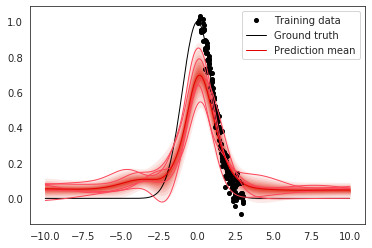

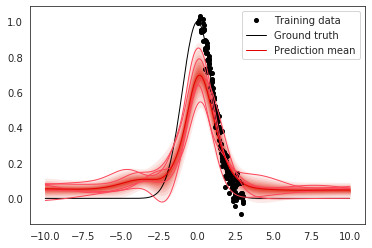

In [14]:
bnn = copy.deepcopy(sauv)
bnn.copy_optimised_priors()
x_train, y_train, x_val, y_val, x_all, y_all = get_1D_data_from_func(150, sigma=0.05, f = function_dict["exponential"])
dataloader_train = DataLoader(
    TensorDataset(x_train, y_train), batch_size=32, shuffle=True
)
optimizer = torch.optim.Adam(bnn.parameters(), lr=0.1)
bnn_vi = train(
    bnn,
    optimizer,
    dataloader_train,
    n_epochs=500,
    log_dir=None,
    evaluate_func=eval_1d_regression,
    evaluate_data=(x_train, y_train, x_val, y_val, x_all, y_all, 20),
    model_noise_var=0.1,
    M=1,
)
# create and save figure
y_all_pred = sample_bnn(bnn_vi ,x_all, 5, train=False).squeeze(-1).squeeze(-1).cpu().numpy().T
x_train, y_train, x_val, y_val, x_all, y_all = x_train.squeeze(-1).cpu().numpy(), y_train.squeeze(-1).cpu().numpy(), x_val.squeeze(-1).cpu().numpy(),\
y_val.squeeze(-1).cpu().numpy(), x_all.squeeze(-1).cpu().numpy(), y_all.squeeze(-1).cpu().numpy()
title = "regression results on bnn with optimized prior - On e^-x^2 function"
plot_deciles(x_all, y_all_pred, y_all, x_train, y_train, mode="gpp", title=title)

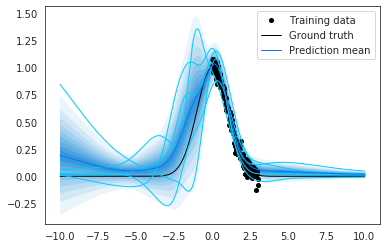

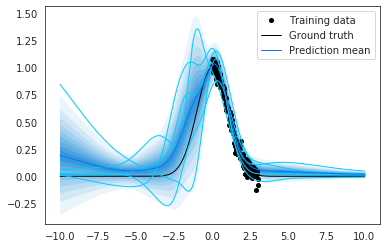

In [15]:
x_train, y_train, x_val, y_val, x_all, y_all = get_1D_data_from_func(150, sigma=0.05, f = exponential)
dataloader_train = DataLoader(
    TensorDataset(x_train, y_train), batch_size=32, shuffle=True
)
optimizer = torch.optim.Adam(bnn_witness.parameters(), lr=0.1)
model = train(
    bnn_witness,
    optimizer,
    dataloader_train,
    n_epochs=500,
    log_dir=None,
    evaluate_func=eval_1d_regression,
    evaluate_data=(x_train, y_train, x_val, y_val, x_all, y_all, 20),
    model_noise_var=0.1,
    M=len(dataloader_train),
)
# create and save figure
y_all_pred = sample_bnn(model ,x_all, 5, train=False).squeeze(-1).squeeze(-1).cpu().numpy().T
x_train, y_train, x_val, y_val, x_all, y_all = x_train.squeeze(-1).cpu().numpy(), y_train.squeeze(-1).cpu().numpy(), x_val.squeeze(-1).cpu().numpy(),\
y_val.squeeze(-1).cpu().numpy(), x_all.squeeze(-1).cpu().numpy(), y_all.squeeze(-1).cpu().numpy()
title = "regression results on plain bnn On exponential function"
plot_deciles(x_all, y_all_pred, y_all, x_train, y_train, mode="bnn", title=title)